In [20]:
import numpy as np

def potential(x, params):
    """
    Example potential V(x) = 0.5 * k * x^2 + b * x, with parameters (k, b).
    This shows how classical data (k, b) can parametrize the quantum system.
    """
    k, b = params
    return 0.5 * k * x**2 + b * x

def action_change(x_path, i, x_new, eps, m, params):
    """
    Compute the change in discretized Euclidean action when
    the i-th bead x_path[i] is replaced by x_new.
    Uses periodic boundary conditions (x_{-1}=x_{N-1}, x_{N}=x_0).
    """
    N = len(x_path)
    im1 = (i - 1) % N
    ip1 = (i + 1) % N
    x_old = x_path[i]
    # Kinetic term: (m/(2ε)) * (x_i - x_{i-1})^2 etc.
    old_kin = m/(2*eps) * ((x_old - x_path[im1])**2 + (x_path[ip1] - x_old)**2)
    new_kin = m/(2*eps) * ((x_new   - x_path[im1])**2 + (x_path[ip1] - x_new)**2)
    # Potential term at slice i:
    old_pot = eps * potential(x_old, params)
    new_pot = eps * potential(x_new,  params)
    return (new_kin + new_pot) - (old_kin + old_pot)

def path_integral_features(params, N_tau=50, beta=1.0, m=1.0, 
                           sweeps=5000, hitsize=1.0, thinning=1):
    """
    Perform path-integral Monte Carlo for a 1D particle with potential parameters 'params'.
    Returns feature vector: [<x>, <x^2>, <x(0)x(beta/2)>] averaged over sampled paths.
      - N_tau: number of time slices (imaginary-time discretization).
      - beta: total imaginary time (inverse temperature).
      - m: mass of the particle.
      - sweeps: number of Metropolis sweeps (one sweep updates all slices).
      - hitsize: maximum random step size for proposals.
      - thinning: sample every 'thinning'-th sweep to reduce autocorrelation.
    """
    eps = beta / N_tau
    # Initialize path (e.g., cold start at x=0)
    x_path = np.zeros(N_tau)
    # Accumulators for observables
    sum_x = 0.0
    sum_x2 = 0.0
    sum_corr = 0.0
    count = 0

    # Metropolis Monte Carlo sweeps
    for sweep in range(sweeps):
        # Update each slice in random or sequential order
        for i in range(N_tau):
            # Propose a random local move for x_i
            x_new = x_path[i] + np.random.uniform(-hitsize, hitsize)
            dS = action_change(x_path, i, x_new, eps, m, params)
            # Accept or reject
            if dS <= 0 or np.random.rand() < np.exp(-dS):
                x_path[i] = x_new

        # After each sweep, optionally record observables
        if sweep % thinning == 0:
            x_avg = np.mean(x_path)         # <x> along path
            x2_avg = np.mean(x_path**2)     # <x^2>
            # Correlation between x(0) and x(beta/2) on the loop
            shift = N_tau // 2
            corr = np.mean(x_path * np.roll(x_path, shift))
            sum_x  += x_avg
            sum_x2 += x2_avg
            sum_corr += corr
            count += 1

    # Return averaged features over all sampled paths
    return np.array([sum_x/count, sum_x2/count, sum_corr/count])

# Example usage: Transform a toy dataset of (k,b) potentials
data = np.array([
    [1.0, 0.0],
    [1.0, 0.5],
    [2.0, 0.0],
    [2.0, 0.5]
])
features = []
for params in data:
    feat = path_integral_features(params, N_tau=50, beta=5.0, sweeps=5000, hitsize=0.5, thinning=5)
    features.append(feat)
features = np.array(features)
print("Input (k,b) parameters:\n", data)
print("Extracted features [<x>, <x^2>, <x0*x_half>]:\n", np.round(features,3))


Input (k,b) parameters:
 [[1.  0. ]
 [1.  0.5]
 [2.  0. ]
 [2.  0.5]]
Extracted features [<x>, <x^2>, <x0*x_half>]:
 [[-0.06   0.566  0.129]
 [-0.428  0.641  0.321]
 [ 0.124  0.308  0.037]
 [-0.202  0.411  0.141]]


Baseline logistic regression accuracy on raw 2D inputs: 0.487
Transforming train set...
Transformed 50/160 samples (elapsed 8.6s)
Transformed 100/160 samples (elapsed 17.5s)
Transformed 150/160 samples (elapsed 25.8s)
Transformed 160/160 samples (elapsed 27.4s)
Transforming test set...
Transformed 50/80 samples (elapsed 8.4s)
Transformed 80/80 samples (elapsed 13.7s)
Logistic regression accuracy on path-integral features: 0.537


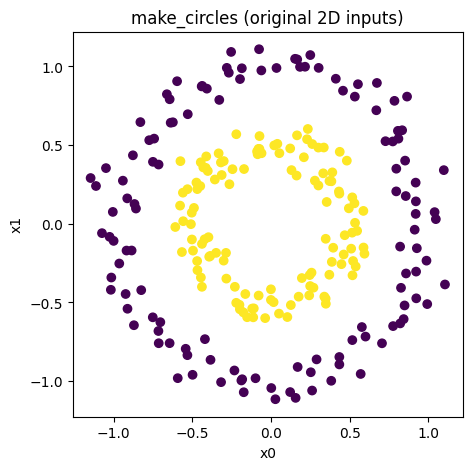

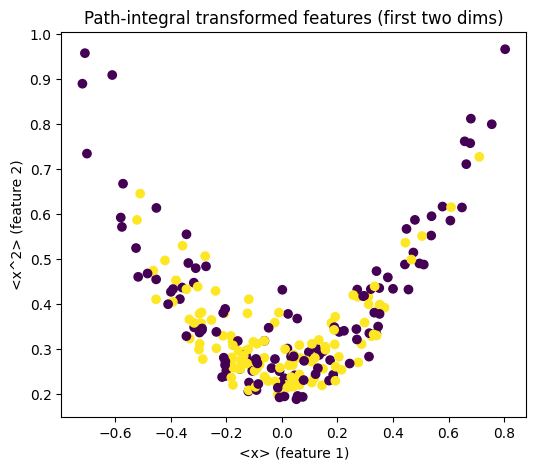

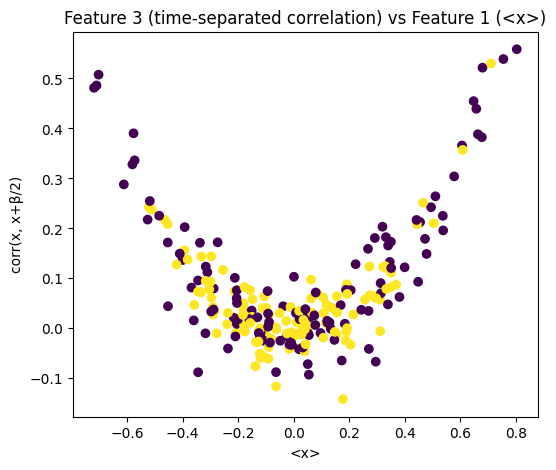

In [26]:
# Path-integral feature transform applied to sklearn.datasets.make_circles
# - This cell runs a classical Path-Integral Monte Carlo (PIMC) sampler per data point
#   and extracts features ⟨x⟩, ⟨x^2⟩, and a time-separated correlation as the transformed features.
# - The 2D input (x1, x2) is mapped to potential parameters k, b via:
#       V(x) = 0.5 * k * x^2 + b * x
#   where k <- scaled x1, b <- scaled x2 (scaling keeps potentials numerically stable).
# - We compare a simple logistic-regression classifier on the original 2D inputs and on
#   the transformed features to illustrate the effect of the path-integral transformation.
#
# Notes on parameter choices (tradeoff accuracy vs runtime):
#  - N_tau (imaginary-time slices): more slices → better approximation, slower.
#  - sweeps (Metropolis sweeps): more sweeps → lower Monte Carlo noise, slower.
#  - thinning: sample every `thinning` sweeps to reduce autocorrelation in stored samples.
#  - For demonstration we use modest values so the script runs fast on typical machines.
#
# Equations (short recap):
#  - Discretized Euclidean action for path x_0..x_{N-1} with eps = beta/N:
#       S_E ≈ Σ_j [ m/(2 eps) (x_{j+1}-x_j)^2 + eps * V(x_j) ]
#  - Local action change when replacing x_i with x'_i (periodic boundary):
#       ΔS = [new_kin + new_pot] - [old_kin + old_pot]
#    where old_kin = m/(2 eps) ((x_i-x_{i-1})^2 + (x_{i+1}-x_i)^2)
#          new_kin similarly with x'_i.
#  - Metropolis acceptance probability: accept with probability min(1, exp(-ΔS/ħ)).
#    We set ħ = 1 for convenience.
#
# Run the experiment below.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import time

# -------------------- Core path-integral functions --------------------
def potential(x, params):
    """
    Quadratic + linear potential: V(x) = 0.5 * k * x^2 + b * x
    params: (k, b)
    """
    k, b = params
    return 0.5 * k * x**2 + b * x

def action_change(x_path, i, x_new, eps, m, params):
    """
    Compute change in discretized Euclidean action when x_path[i] -> x_new
    Periodic boundary conditions enforced.
    """
    N = len(x_path)
    im1 = (i - 1) % N
    ip1 = (i + 1) % N
    x_old = x_path[i]
    old_kin = m/(2*eps) * ((x_old - x_path[im1])**2 + (x_path[ip1] - x_old)**2)
    new_kin = m/(2*eps) * ((x_new   - x_path[im1])**2 + (x_path[ip1] - x_new)**2)
    old_pot = eps * potential(x_old, params)
    new_pot = eps * potential(x_new,  params)
    return (new_kin + new_pot) - (old_kin + old_pot)

def path_integral_features(params, N_tau=40, beta=4.0, m=1.0,
                           sweeps=800, hitsize=0.6, thinning=4, burn_in=200):
    """
    Perform PIMC and return three features: <x>, <x^2>, <x(0)x(beta/2)> averaged over samples.
    - thinning: record every `thinning`-th sweep after burn_in.
    - burn_in: initial sweeps to discard for equilibration.
    """
    eps = beta / N_tau
    # Initialize path at small random values to avoid pathological stuckness
    x_path = np.random.normal(scale=0.1, size=N_tau)
    samples_collected = 0
    sum_x = 0.0
    sum_x2 = 0.0
    sum_corr = 0.0

    total_sweeps = sweeps
    for sweep in range(total_sweeps):
        for i in range(N_tau):
            x_new = x_path[i] + np.random.uniform(-hitsize, hitsize)
            dS = action_change(x_path, i, x_new, eps, m, params)
            # set hbar = 1
            if dS <= 0 or np.random.rand() < np.exp(-dS):
                x_path[i] = x_new
        # after each sweep, possibly record (post burn-in)
        if sweep >= burn_in and ((sweep - burn_in) % thinning == 0):
            x_avg = np.mean(x_path)
            x2_avg = np.mean(x_path**2)
            shift = N_tau // 2
            corr = np.mean(x_path * np.roll(x_path, shift))
            sum_x += x_avg
            sum_x2 += x2_avg
            sum_corr += corr
            samples_collected += 1
    if samples_collected == 0:
        # fallback
        return np.array([np.mean(x_path), np.mean(x_path**2), np.mean(x_path * np.roll(x_path, N_tau//2))])
    return np.array([sum_x/samples_collected, sum_x2/samples_collected, sum_corr/samples_collected])

# -------------------- Data mapping + transform --------------------
def map_point_to_params(pt, scale_k=1.0, scale_b=1.0):
    """
    Map a d-dimensional point pt -> potential parameters (k,b).
    For 2D inputs: k = scale_k * x1, b = scale_b * x2.
    For higher dims, we take first two components; you can design more complex mappings.
    """
    if len(pt) >= 2:
        k = scale_k * pt[0]
        b = scale_b * pt[1]
    elif len(pt) == 1:
        k = scale_k * pt[0]
        b = 0.0
    else:
        k, b = 1.0, 0.0
    # stabilize k to avoid extremely deep inverted parabolas:
    # keep k within a reasonable positive range by shifting and clipping
    k = float(k)
    b = float(b)
    # apply soft transform to keep numeric stable: map k -> k_shifted in [0.1, 5]
    k_shifted = 0.1 + 4.9 * (1.0 / (1.0 + np.exp(-k)))  # sigmoid mapping
    return (k_shifted, b)

def transform_dataset(X, N_tau=40, beta=4.0, m=1.0, sweeps=800, hitsize=0.6, thinning=4, burn_in=200):
    """
    Transform dataset X (n_samples, d) into path-integral features per row.
    Returns array (n_samples, 3).
    """
    n = X.shape[0]
    feats = np.zeros((n, 3))
    t0 = time.time()
    for i in range(n):
        params = map_point_to_params(X[i], scale_k=1.0, scale_b=1.0)
        feats[i] = path_integral_features(params, N_tau=N_tau, beta=beta, m=m,
                                          sweeps=sweeps, hitsize=hitsize, thinning=thinning, burn_in=burn_in)
        if (i+1) % 50 == 0 or i == n-1:
            elapsed = time.time() - t0
            print(f"Transformed {i+1}/{n} samples (elapsed {elapsed:.1f}s)")
    return feats

# -------------------- Run on make_circles --------------------
# generate dataset
X, y = make_circles(n_samples=240, factor=0.5, noise=0.08, random_state=1)
# train/test split for classification comparisons
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2, stratify=y)

# Baseline: logistic regression on raw 2D inputs
clf_raw = LogisticRegression(max_iter=2000)
clf_raw.fit(X_train, y_train)
y_pred_raw = clf_raw.predict(X_test)
acc_raw = accuracy_score(y_test, y_pred_raw)
print(f"Baseline logistic regression accuracy on raw 2D inputs: {acc_raw:.3f}")

# Transform the dataset (this will take some seconds)
print("Transforming train set...")
X_train_t = transform_dataset(X_train, N_tau=40, beta=4.0, m=1.0, sweeps=700, hitsize=0.6, thinning=3, burn_in=150)
print("Transforming test set...")
X_test_t  = transform_dataset(X_test,  N_tau=40, beta=4.0, m=1.0, sweeps=700, hitsize=0.6, thinning=3, burn_in=150)

# Train classifier on transformed features
clf_trans = LogisticRegression(max_iter=2000)
clf_trans.fit(X_train_t, y_train)
y_pred_trans = clf_trans.predict(X_test_t)
acc_trans = accuracy_score(y_test, y_pred_trans)
print(f"Logistic regression accuracy on path-integral features: {acc_trans:.3f}")

# -------------------- Visualizations --------------------
# 1) original dataset scatter
plt.figure(figsize=(6,5))
plt.title("make_circles (original 2D inputs)")
plt.scatter(X[:,0], X[:,1], c=y)   # don't explicitly set a colormap
plt.xlabel("x0"); plt.ylabel("x1")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# 2) transformed features (use first two extracted features for plotting)
plt.figure(figsize=(6,5))
plt.title("Path-integral transformed features (first two dims)")
# combine train+test transformed to plot overall
X_all_t = np.vstack([X_train_t, X_test_t])
y_all = np.concatenate([y_train, y_test])
plt.scatter(X_all_t[:,0], X_all_t[:,1], c=y_all)
plt.xlabel("<x> (feature 1)"); plt.ylabel("<x^2> (feature 2)")
plt.gca().set_aspect('auto')
plt.show()

# 3) show transformed features distribution per class (simple pair plot-ish)
plt.figure(figsize=(6,5))
plt.title("Feature 3 (time-separated correlation) vs Feature 1 (<x>)")
plt.scatter(X_all_t[:,0], X_all_t[:,2], c=y_all)
plt.xlabel("<x>"); plt.ylabel("corr(x, x+β/2)")
plt.show()


In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, balanced_accuracy_score

# -------------------- Prepare augmented features --------------------
# Standardize classical features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

# Standardize path-integral features
scaler_pi = StandardScaler()
X_train_pi = scaler_pi.fit_transform(X_train_t)
X_test_pi  = scaler_pi.transform(X_test_t)

# Concatenate classical + quantum features
X_train_aug = np.hstack([X_train_std, X_train_pi])
X_test_aug  = np.hstack([X_test_std, X_test_pi])

# -------------------- Define GradientBoostingClassifier --------------------
clf_gb = GradientBoostingClassifier(random_state=42)

# Define cross-validation splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring dictionary
scoring = {
    'AUC': 'roc_auc',
    'F1': make_scorer(f1_score),
    'BalancedAcc': make_scorer(balanced_accuracy_score)
}

# -------------------- Cross-validate --------------------
print("Cross-validating on augmented features (classical + quantum)...")
cv_results_aug = cross_validate(clf_gb, X_train_aug, y_train, cv=cv, scoring=scoring, return_train_score=False)
print("AUC (mean ± std): {:.3f} ± {:.3f}".format(np.mean(cv_results_aug['test_AUC']), np.std(cv_results_aug['test_AUC'])))
print("F1 (mean ± std): {:.3f} ± {:.3f}".format(np.mean(cv_results_aug['test_F1']), np.std(cv_results_aug['test_F1'])))
print("BalancedAcc (mean ± std): {:.3f} ± {:.3f}".format(np.mean(cv_results_aug['test_BalancedAcc']), np.std(cv_results_aug['test_BalancedAcc'])))

# -------------------- Evaluate on holdout test set --------------------
clf_gb.fit(X_train_aug, y_train)
y_test_pred = clf_gb.predict(X_test_aug)
y_test_prob = clf_gb.predict_proba(X_test_aug)[:,1]

auc_test = roc_auc_score(y_test, y_test_prob)
f1_test = f1_score(y_test, y_test_pred)
bacc_test = balanced_accuracy_score(y_test, y_test_pred)

print("\nTest set evaluation:")
print(f"AUC: {auc_test:.3f}, F1: {f1_test:.3f}, BalancedAcc: {bacc_test:.3f}")

# Classical features only
cv_results_classical = cross_validate(clf_gb, X_train_std, y_train, cv=cv, scoring=scoring)
print("\nCross-validating on classical features only...")
print("AUC (mean ± std): {:.3f} ± {:.3f}".format(np.mean(cv_results_classical['test_AUC']), np.std(cv_results_classical['test_AUC'])))
print("F1 (mean ± std): {:.3f} ± {:.3f}".format(np.mean(cv_results_classical['test_F1']), np.std(cv_results_classical['test_F1'])))
print("BalancedAcc (mean ± std): {:.3f} ± {:.3f}".format(np.mean(cv_results_classical['test_BalancedAcc']), np.std(cv_results_classical['test_BalancedAcc'])))

Cross-validating on augmented features (classical + quantum)...
AUC (mean ± std): 1.000 ± 0.000
F1 (mean ± std): 0.988 ± 0.015
BalancedAcc (mean ± std): 0.988 ± 0.015

Test set evaluation:
AUC: 0.999, F1: 0.964, BalancedAcc: 0.963

Cross-validating on classical features only...
AUC (mean ± std): 1.000 ± 0.000
F1 (mean ± std): 0.988 ± 0.015
BalancedAcc (mean ± std): 0.988 ± 0.015


Transforming train set...
Transformed 50/268 samples (elapsed 9.1s)
Transformed 100/268 samples (elapsed 18.0s)
Transformed 150/268 samples (elapsed 27.3s)
Transformed 200/268 samples (elapsed 36.3s)
Transformed 250/268 samples (elapsed 44.9s)
Transformed 268/268 samples (elapsed 48.0s)
Transforming test set...
Transformed 50/132 samples (elapsed 8.9s)
Transformed 100/132 samples (elapsed 17.4s)
Transformed 132/132 samples (elapsed 22.9s)
Classical features - CV results:
CV AUC: 0.654 ± 0.037
CV F1: 0.662 ± 0.016
CV BalancedAcc: 0.638 ± 0.028

Path-integral features - CV results:
CV AUC: 0.475 ± 0.101
CV F1: 0.475 ± 0.084
CV BalancedAcc: 0.463 ± 0.064

Augmented features (classical + path-integral) - CV results:
CV AUC: 0.654 ± 0.064
CV F1: 0.634 ± 0.032
CV BalancedAcc: 0.619 ± 0.050


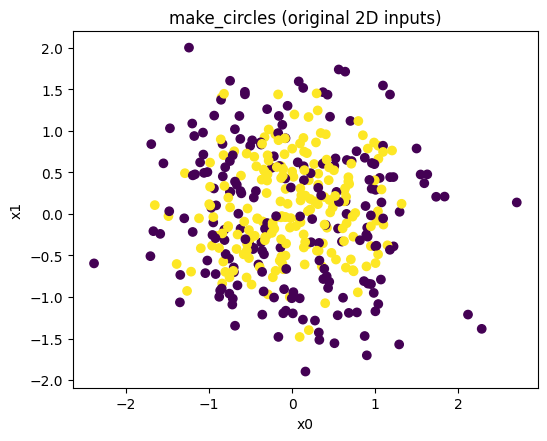

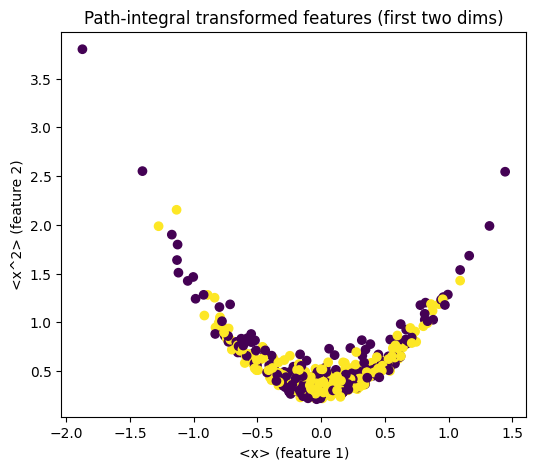

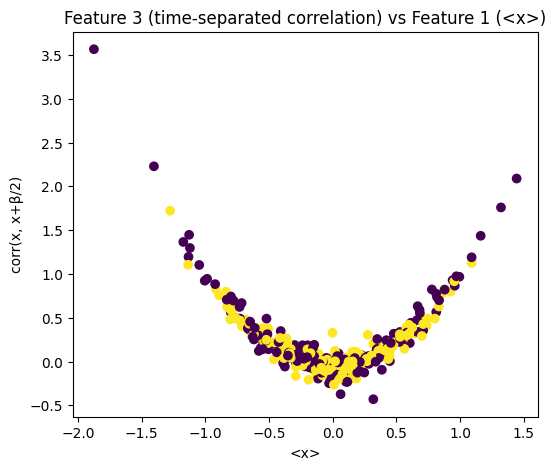

In [35]:
# Path-integral feature transform applied to sklearn.datasets.make_circles
# Classical + path-integral features evaluated using GradientBoostingClassifier with cross-validation

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, balanced_accuracy_score
import time

# -------------------- Core path-integral functions --------------------
def potential(x, params):
    k, b = params
    return 0.5 * k * x**2 + b * x

def potential_anharmonic(x, params):
    k2, k4, b = params  # quadratic, quartic, linear
    return 0.5 * k2 * x**2 + 0.25 * k4 * x**4 + b * x


def action_change(x_path, i, x_new, eps, m, params):
    N = len(x_path)
    im1 = (i - 1) % N
    ip1 = (i + 1) % N
    x_old = x_path[i]
    old_kin = m/(2*eps) * ((x_old - x_path[im1])**2 + (x_path[ip1] - x_old)**2)
    new_kin = m/(2*eps) * ((x_new - x_path[im1])**2 + (x_path[ip1] - x_new)**2)
    old_pot = eps * potential_anharmonic(x_old, params)
    new_pot = eps * potential_anharmonic(x_new, params)
    return (new_kin + new_pot) - (old_kin + old_pot)

def path_integral_features(params, N_tau=40, beta=4.0, m=1.0,
                           sweeps=800, hitsize=0.6, thinning=4, burn_in=200):
    eps = beta / N_tau
    x_path = np.random.normal(scale=0.1, size=N_tau)
    samples_collected = 0
    sum_x = sum_x2 = sum_corr = 0.0

    for sweep in range(sweeps):
        for i in range(N_tau):
            x_new = x_path[i] + np.random.uniform(-hitsize, hitsize)
            dS = action_change(x_path, i, x_new, eps, m, params)
            if dS <= 0 or np.random.rand() < np.exp(-dS):
                x_path[i] = x_new
        if sweep >= burn_in and ((sweep - burn_in) % thinning == 0):
            x_avg = np.mean(x_path)
            x2_avg = np.mean(x_path**2)
            shift = N_tau // 2
            corr = np.mean(x_path * np.roll(x_path, shift))
            sum_x += x_avg
            sum_x2 += x2_avg
            sum_corr += corr
            samples_collected += 1
    if samples_collected == 0:
        return np.array([np.mean(x_path), np.mean(x_path**2), np.mean(x_path * np.roll(x_path, N_tau//2))])
    return np.array([sum_x/samples_collected, sum_x2/samples_collected, sum_corr/samples_collected])

# -------------------- Data mapping + transform --------------------
"""
def map_point_to_params(pt, scale_k=1.0, scale_b=1.0):
    if len(pt) >= 2:
        k = scale_k * pt[0]
        b = scale_b * pt[1]
    elif len(pt) == 1:
        k = scale_k * pt[0]
        b = 0.0
    else:
        k, b = 1.0, 0.0
    k_shifted = 0.1 + 4.9 * (1.0 / (1.0 + np.exp(-k)))
    return (k_shifted, b)
"""
    
def map_point_to_params(x, scale_k2=1.0, scale_k4=0.5, scale_b=0.0):
    """
    Map a 2D point to anharmonic potential parameters: k2 (quadratic), k4 (quartic), b (linear)
    """
    x1, x2 = x[0], x[1]
    k2 = scale_k2 * x1
    k4 = scale_k4  # constant quartic term, positive to stabilize
    b  = scale_b * x2
    # Optionally, clip or shift k2 to create a double-well:
    k2 = np.clip(k2, -5.0, 5.0)
    return (k2, k4, b)


def transform_dataset(X, N_tau=40, beta=4.0, m=1.0, sweeps=800, hitsize=0.6, thinning=4, burn_in=200):
    n = X.shape[0]
    feats = np.zeros((n, 3))
    t0 = time.time()
    for i in range(n):
        params = map_point_to_params(X[i])
        feats[i] = path_integral_features(params, N_tau=N_tau, beta=beta, m=m,
                                          sweeps=sweeps, hitsize=hitsize, thinning=thinning, burn_in=burn_in)
        if (i+1) % 50 == 0 or i == n-1:
            elapsed = time.time() - t0
            print(f"Transformed {i+1}/{n} samples (elapsed {elapsed:.1f}s)")
    return feats

# -------------------- Generate dataset --------------------
X, y = make_circles(n_samples=400, factor=0.5, noise=0.5, random_state=1)
#X, y = make_spirals(n_samples=300, noise=0.1, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2, stratify=y)

# -------------------- Path-integral feature transformation --------------------
print("Transforming train set...")
X_train_t = transform_dataset(X_train, N_tau=40, beta=4.0, m=1.0, sweeps=700, hitsize=0.6, thinning=3, burn_in=150)
print("Transforming test set...")
X_test_t = transform_dataset(X_test, N_tau=40, beta=4.0, m=1.0, sweeps=700, hitsize=0.6, thinning=3, burn_in=150)

# -------------------- Standardize features --------------------
scaler_classical = StandardScaler()
X_train_std = scaler_classical.fit_transform(X_train)
X_test_std  = scaler_classical.transform(X_test)

scaler_pi = StandardScaler()
X_train_pi = scaler_pi.fit_transform(X_train_t)
X_test_pi  = scaler_pi.transform(X_test_t)

# Concatenate classical + quantum features
X_train_aug = np.hstack([X_train_std, X_train_pi])
X_test_aug  = np.hstack([X_test_std, X_test_pi])

# -------------------- Gradient Boosting CV for classical features --------------------
clf_gb_classical = GradientBoostingClassifier(random_state=42)
cv_results_classical = cross_validate(clf_gb_classical, X_train_std, y_train, cv=cv, scoring=scoring, return_train_score=False)

print("Classical features - CV results:")
print("CV AUC: {:.3f} ± {:.3f}".format(np.mean(cv_results_classical['test_AUC']), np.std(cv_results_classical['test_AUC'])))
print("CV F1: {:.3f} ± {:.3f}".format(np.mean(cv_results_classical['test_F1']), np.std(cv_results_classical['test_F1'])))
print("CV BalancedAcc: {:.3f} ± {:.3f}".format(np.mean(cv_results_classical['test_BalancedAcc']), np.std(cv_results_classical['test_BalancedAcc'])))

# -------------------- Gradient Boosting CV for path-integral features --------------------
clf_gb_pi = GradientBoostingClassifier(random_state=42)
cv_results_pi = cross_validate(clf_gb_pi, X_train_pi, y_train, cv=cv, scoring=scoring, return_train_score=False)

print("\nPath-integral features - CV results:")
print("CV AUC: {:.3f} ± {:.3f}".format(np.mean(cv_results_pi['test_AUC']), np.std(cv_results_pi['test_AUC'])))
print("CV F1: {:.3f} ± {:.3f}".format(np.mean(cv_results_pi['test_F1']), np.std(cv_results_pi['test_F1'])))
print("CV BalancedAcc: {:.3f} ± {:.3f}".format(np.mean(cv_results_pi['test_BalancedAcc']), np.std(cv_results_pi['test_BalancedAcc'])))

# -------------------- Gradient Boosting CV for augmented features --------------------
clf_gb_aug = GradientBoostingClassifier(random_state=42)
cv_results_aug = cross_validate(clf_gb_aug, X_train_aug, y_train, cv=cv, scoring=scoring, return_train_score=False)

print("\nAugmented features (classical + path-integral) - CV results:")
print("CV AUC: {:.3f} ± {:.3f}".format(np.mean(cv_results_aug['test_AUC']), np.std(cv_results_aug['test_AUC'])))
print("CV F1: {:.3f} ± {:.3f}".format(np.mean(cv_results_aug['test_F1']), np.std(cv_results_aug['test_F1'])))
print("CV BalancedAcc: {:.3f} ± {:.3f}".format(np.mean(cv_results_aug['test_BalancedAcc']), np.std(cv_results_aug['test_BalancedAcc'])))


# -------------------- Visualizations --------------------
plt.figure(figsize=(6,5))
plt.title("make_circles (original 2D inputs)")
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlabel("x0"); plt.ylabel("x1")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

plt.figure(figsize=(6,5))
plt.title("Path-integral transformed features (first two dims)")
X_all_t = np.vstack([X_train_t, X_test_t])
y_all = np.concatenate([y_train, y_test])
plt.scatter(X_all_t[:,0], X_all_t[:,1], c=y_all)
plt.xlabel("<x> (feature 1)"); plt.ylabel("<x^2> (feature 2)")
plt.gca().set_aspect('auto')
plt.show()

plt.figure(figsize=(6,5))
plt.title("Feature 3 (time-separated correlation) vs Feature 1 (<x>)")
plt.scatter(X_all_t[:,0], X_all_t[:,2], c=y_all)
plt.xlabel("<x>"); plt.ylabel("corr(x, x+β/2)")
plt.show()


Transforming train set with spin-Ising PIMC...
Transformed 50/160 samples
Transformed 100/160 samples
Transformed 150/160 samples
Transformed 160/160 samples
Transforming test set with spin-Ising PIMC...
Transformed 50/80 samples
Transformed 80/80 samples
Classical features - CV results:
AUC: 0.663 ± 0.114
F1: 0.610 ± 0.087
BalancedAcc: 0.600 ± 0.091

Spin-Ising PIMC features - CV results:
AUC: 0.475 ± 0.083
F1: 0.476 ± 0.064
BalancedAcc: 0.475 ± 0.080

Augmented features - CV results:
AUC: 0.616 ± 0.094
F1: 0.546 ± 0.057
BalancedAcc: 0.544 ± 0.058

Test set evaluation (augmented features):
AUC: 0.537, F1: 0.565, BalancedAcc: 0.537


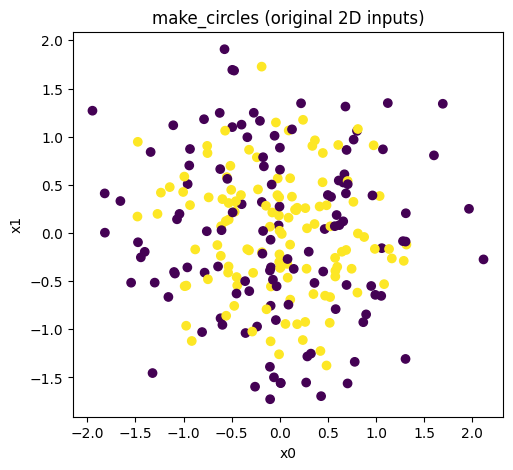

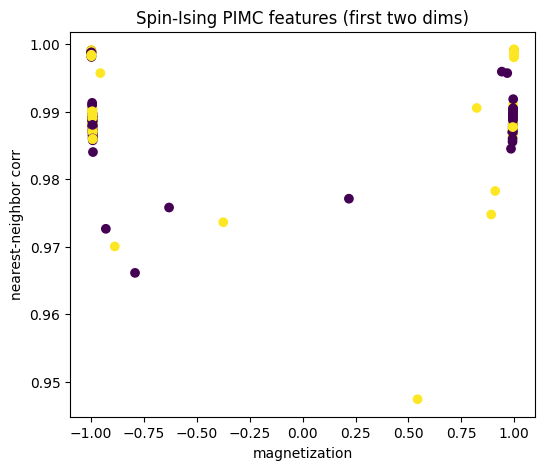

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, balanced_accuracy_score

# -------------------- Spin-Ising PIMC functions --------------------
def ising_hamiltonian_features(J, h, N_tau=40, sweeps=800, burn_in=200, thinning=4):
    """
    1D classical Ising path-integral Monte Carlo.
    Returns features: [avg magnetization, nearest-neighbor correlation, half-time correlation]
    """
    N_spin = len(J)
    spins = np.random.choice([-1, 1], size=(N_spin, N_tau))
    
    sum_m = sum_corr_nn = sum_corr_half = 0.0
    samples_collected = 0
    
    for sweep in range(sweeps):
        for t in range(N_tau):
            for i in range(N_spin):
                s_old = spins[i,t]
                s_new = -s_old
                im1 = (i-1) % N_spin
                ip1 = (i+1) % N_spin
                t_prev = (t-1) % N_tau
                t_next = (t+1) % N_tau
                delta_E = -2 * s_new * (J[i]*(spins[im1,t]+spins[ip1,t]) + h[i] + spins[i,t_prev]+spins[i,t_next])
                if delta_E <= 0 or np.random.rand() < np.exp(-delta_E):
                    spins[i,t] = s_new
        if sweep >= burn_in and (sweep - burn_in) % thinning == 0:
            m_avg = np.mean(spins)
            corr_nn = np.mean(spins * np.roll(spins, 1, axis=0))
            corr_half = np.mean(spins * np.roll(spins, N_tau//2, axis=1))
            sum_m += m_avg
            sum_corr_nn += corr_nn
            sum_corr_half += corr_half
            samples_collected += 1
            
    return np.array([sum_m/samples_collected,
                     sum_corr_nn/samples_collected,
                     sum_corr_half/samples_collected])

def map_point_to_ising_params(x, N_spin=10):
    """
    Map 2D point x to Ising spin chain parameters (J, h)
    """
    r = np.sqrt(x[0]**2 + x[1]**2)
    theta = np.arctan2(x[1], x[0])
    # Coupling: stronger for inner circle, weaker for outer
    J = np.ones(N_spin) * (1.0 if r < 0.5 else 0.5)
    # Small local field to break symmetry slightly
    h = np.ones(N_spin) * 0.1 * np.cos(theta)
    return J, h

def transform_dataset_ising(X, N_spin=10, N_tau=40, sweeps=700, burn_in=150, thinning=3):
    """
    Transform dataset X (n_samples, 2) into 3 spin-Ising PIMC features
    """
    n = X.shape[0]
    feats = np.zeros((n, 3))
    for i in range(n):
        J, h = map_point_to_ising_params(X[i], N_spin)
        feats[i] = ising_hamiltonian_features(J, h, N_tau=N_tau, sweeps=sweeps, burn_in=burn_in, thinning=thinning)
        if (i+1) % 50 == 0 or i == n-1:
            print(f"Transformed {i+1}/{n} samples")
    return feats

# -------------------- Generate dataset --------------------
X, y = make_circles(n_samples=240, factor=0.5, noise=0.5, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2, stratify=y)

# -------------------- Transform features --------------------
print("Transforming train set with spin-Ising PIMC...")
X_train_pimc = transform_dataset_ising(X_train)
print("Transforming test set with spin-Ising PIMC...")
X_test_pimc = transform_dataset_ising(X_test)

# -------------------- Standardize features --------------------
scaler_classical = StandardScaler()
X_train_std = scaler_classical.fit_transform(X_train)
X_test_std = scaler_classical.transform(X_test)

scaler_pimc = StandardScaler()
X_train_pimc_std = scaler_pimc.fit_transform(X_train_pimc)
X_test_pimc_std  = scaler_pimc.transform(X_test_pimc)

# Augmented features: classical + PIMC
X_train_aug = np.hstack([X_train_std, X_train_pimc_std])
X_test_aug  = np.hstack([X_test_std, X_test_pimc_std])

# -------------------- Gradient Boosting with CV --------------------
clf_gb = GradientBoostingClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'AUC':'roc_auc', 'F1': make_scorer(f1_score), 'BalancedAcc': make_scorer(balanced_accuracy_score)}

# Classical features only
cv_classical = cross_validate(clf_gb, X_train_std, y_train, cv=cv, scoring=scoring)
print("Classical features - CV results:")
print("AUC: {:.3f} ± {:.3f}".format(np.mean(cv_classical['test_AUC']), np.std(cv_classical['test_AUC'])))
print("F1: {:.3f} ± {:.3f}".format(np.mean(cv_classical['test_F1']), np.std(cv_classical['test_F1'])))
print("BalancedAcc: {:.3f} ± {:.3f}".format(np.mean(cv_classical['test_BalancedAcc']), np.std(cv_classical['test_BalancedAcc'])))

# Spin-Ising PIMC features only
cv_pimc = cross_validate(clf_gb, X_train_pimc_std, y_train, cv=cv, scoring=scoring)
print("\nSpin-Ising PIMC features - CV results:")
print("AUC: {:.3f} ± {:.3f}".format(np.mean(cv_pimc['test_AUC']), np.std(cv_pimc['test_AUC'])))
print("F1: {:.3f} ± {:.3f}".format(np.mean(cv_pimc['test_F1']), np.std(cv_pimc['test_F1'])))
print("BalancedAcc: {:.3f} ± {:.3f}".format(np.mean(cv_pimc['test_BalancedAcc']), np.std(cv_pimc['test_BalancedAcc'])))

# Augmented features
cv_aug = cross_validate(clf_gb, X_train_aug, y_train, cv=cv, scoring=scoring)
print("\nAugmented features - CV results:")
print("AUC: {:.3f} ± {:.3f}".format(np.mean(cv_aug['test_AUC']), np.std(cv_aug['test_AUC'])))
print("F1: {:.3f} ± {:.3f}".format(np.mean(cv_aug['test_F1']), np.std(cv_aug['test_F1'])))
print("BalancedAcc: {:.3f} ± {:.3f}".format(np.mean(cv_aug['test_BalancedAcc']), np.std(cv_aug['test_BalancedAcc'])))

# -------------------- Test set evaluation --------------------
clf_gb.fit(X_train_aug, y_train)
y_pred_test = clf_gb.predict(X_test_aug)
y_prob_test = clf_gb.predict_proba(X_test_aug)[:,1]

auc_test = roc_auc_score(y_test, y_prob_test)
f1_test = f1_score(y_test, y_pred_test)
bacc_test = balanced_accuracy_score(y_test, y_pred_test)
print("\nTest set evaluation (augmented features):")
print(f"AUC: {auc_test:.3f}, F1: {f1_test:.3f}, BalancedAcc: {bacc_test:.3f}")

# -------------------- Visualizations --------------------
plt.figure(figsize=(6,5))
plt.title("make_circles (original 2D inputs)")
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlabel("x0"); plt.ylabel("x1")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

plt.figure(figsize=(6,5))
plt.title("Spin-Ising PIMC features (first two dims)")
X_all_pimc = np.vstack([X_train_pimc, X_test_pimc])
y_all = np.concatenate([y_train, y_test])
plt.scatter(X_all_pimc[:,0], X_all_pimc[:,1], c=y_all)
plt.xlabel("magnetization"); plt.ylabel("nearest-neighbor corr")
plt.gca().set_aspect('auto')
plt.show()
